In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.layers import Dense,Bidirectional,CuDNNLSTM,CuDNNGRU,Flatten,Conv1D,Embedding,Dropout,BatchNormalization
from keras.layers import LSTM,GRU,Activation,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,SpatialDropout1D,Input
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint,Callback, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.optimizers import Adam
import keras.backend as K
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
import gensim.models.keyedvectors as word2vec
from tqdm import tqdm
tqdm.pandas()
import os
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['quoratextemb', 'innoplexusav']


In [2]:
# def load_embed(file):
#     def get_coefs(word,*arr): 
#         return word, np.asarray(arr, dtype='float32')
    
#     if file == '../input/quoratextemb/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
#         embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
#     else:
#         embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
#     return embeddings_index

In [3]:
paragram_path='../input/quoratextemb/embeddings/paragram_300_sl999/paragram_300_sl999.txt'

In [4]:
glove_path='../input/quoratextemb/embeddings/glove.840B.300d/glove.840B.300d.txt'

In [5]:
fasttext_path='../input/quoratextemb/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

In [6]:
traindf=pd.read_csv('../input/innoplexusav/train.csv')
testdf=pd.read_csv('../input/innoplexusav/test.csv')

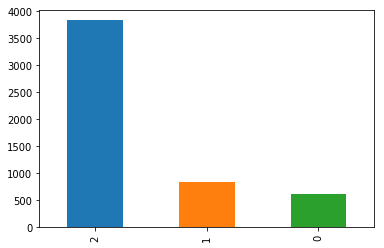

In [7]:
traindf.sentiment.value_counts().plot.bar()

In [8]:
# text_0=traindf[traindf['sentiment']==0].sample(n=1500,random_state=5,replace=True)
# text_2=traindf[traindf['sentiment']==2].sample(n=1500,random_state=5)
# text_1=traindf[traindf['sentiment']==1].sample(n=1500,random_state=5,replace=True)

# traindf=pd.concat([text_0,text_1,text_2],axis=0,ignore_index=True)
# traindf=traindf.sample(frac=1).reset_index(drop=True)

In [9]:
ntrain=traindf.shape[0]
data=pd.concat([traindf,testdf],axis=0,ignore_index=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [10]:
# stop_words=set(stopwords.words('english'))

# def clean_text(row):
#     tokens=word_tokenize(row)
#     filtered_text=[word.lower() for word in tokens if ((word.lower() not in (string.punctuation + '“”’')) & (word.lower() not in stop_words))]
#     return ' '.join(filtered_text)

In [11]:
# data['text']=data['text'].apply(lambda x: clean_text(x))

In [12]:
def build_vocab(sentences):
    vocab={}
    for sentence in tqdm(sentences):
        for word in sentence:
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
    return vocab

In [13]:
# sentences=data['text'].progress_apply(lambda x: x.split()).values
# vocab=build_vocab(sentences)

# print({k:vocab[k] for k in list(vocab.keys())[:5]})

In [14]:
# def coverage(vocab,embedding_index):
#     intersection={}
#     i=0
#     oov={}
#     o=0
    
#     for word in tqdm(vocab.keys()):
#         try:
#             intersection[word]=embedding_index[word]
#             i+=vocab[word]
#         except:
#             oov[word]=vocab[word]
#             o+=vocab[word]
#     print(f'Embeddings found for {len(intersection)*100/len(vocab)} of vocab')
#     print(f'Embeddings found for {i*100/(i+o)} of text')
#     oov=sorted(oov.items(),key=lambda x:x[1],reverse=True)
#     return oov

In [15]:
# paragram_oov=coverage(vocab,paragram_index)

In [16]:
data['lowered_text']=data['text'].apply(lambda x: x.lower())
# sentences=data['lowered_text'].progress_apply(lambda x: x.split()).values
# lowered_vocab=build_vocab(sentences)

In [17]:
# paragram_oov=coverage(lowered_vocab,paragram_index)

In [18]:
sentences=data['text'].progress_apply(lambda x: x.split()).values
vocab=build_vocab(sentences)

100%|██████████| 8203/8203 [00:00<00:00, 12006.46it/s]


In [19]:
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [20]:
# add_lower(paragram_index, vocab)
# add_lower(glove_index,vocab)
# add_lower(fasttext_index,vocab)

In [21]:
# paragram_oov=coverage(lowered_vocab,paragram_index)

In [22]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would",
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have",
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                       "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                       "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [23]:
# def known_contractions(embed):
#     known = []
#     for contract in contraction_mapping:
#         if contract in embed:
#             known.append(contract)
#     return known

In [24]:
# print(known_contractions(paragram_index))

In [25]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [26]:
data['treated_text'] = data['lowered_text'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [27]:
# sentences=data['treated_text'].progress_apply(lambda x: x.split()).values
# vocab = build_vocab(sentences)
# oov_paragram = coverage(vocab, paragram_index)

In [28]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [29]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [30]:
# print(unknown_punct(paragram_index, punct))

In [31]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-",
                 "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 
                 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '►':' ','®':'registered trademark ',
                 'â':'a','»':' ','±':'+ -','âe':'e','1â':' ','≥':'> =','‡':'reference mark','🙂':'smile','2â':' ','·':'-',
                 '†':'reference mark','rebif®':'rebif','©':'copyright trademark','≥6':'> = 6','gilenya®':'gilenya','§':' ','8â':' ',
                }

In [32]:
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [33]:
data['treated_text'] = data['treated_text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

In [34]:
# sentences=data['treated_text'].progress_apply(lambda x: x.split()).values
# vocab = build_vocab(sentences)
# oov_paragram = coverage(vocab, paragram_index)

In [35]:
# oov_paragram[:100]

In [36]:
# data['num_words']=data['text'].progress_apply(lambda x: len(x.split()))
# data['num_sentences']=data['text'].progress_apply(lambda x: len(x.split('.')))


In [37]:
# def count_unique_words(text):
#     tokens=word_tokenize(text)
#     unique_words=[word for word in tokens if word.lower() not in paragram_index]
#     return len(unique_words)

In [38]:
# def count_punctuations(text):
#     tokens=word_tokenize(text)
#     punctuations=[word for word in tokens if word.lower() in punct]
#     return len(punctuations)

In [39]:
# data['num_unique_words']=data['text'].progress_apply(lambda x: count_unique_words(x) )
# data['num_punctuation']=data['text'].progress_apply(lambda x: count_punctuations(x))

In [40]:
# def num_capital_letters(text):
#     tokens=word_tokenize(text)
#     capital=[word for word in tokens if word[0].isupper()]
#     return len(capital)

In [41]:
# data['num_capital']=data['text'].progress_apply(lambda x: num_capital_letters(x))

In [42]:
data.head()

,drug,sentiment,text,unique_hash,lowered_text,treated_text
0,gilenya,2.0,Autoimmune diseases tend to come in clusters. ...,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,autoimmune diseases tend to come in clusters. ...,autoimmune diseases tend to come in clusters ....
1,gilenya,2.0,I can completely understand why you’d want to ...,9eba8f80e7e20f3a2f48685530748fbfa95943e4,i can completely understand why you’d want to ...,i can completely understand why you would want...
2,fingolimod,2.0,Interesting that it only targets S1P-1/5 recep...,fe809672251f6bd0d986e00380f48d047c7e7b76,interesting that it only targets s1p-1/5 recep...,interesting that it only targets s1p - 1 / ...
3,ocrevus,2.0,"Very interesting, grand merci. Now I wonder wh...",bd22104dfa9ec80db4099523e03fae7a52735eb6,"very interesting, grand merci. now i wonder wh...","very interesting , grand merci . now i wonde..."
4,gilenya,1.0,"Hi everybody, My latest MRI results for Brain ...",b227688381f9b25e5b65109dd00f7f895e838249,"hi everybody, my latest mri results for brain ...","hi everybody , my latest mri results for brai..."


In [43]:
# le=LabelEncoder()
# data['drug']=le.fit_transform(data['drug'])

In [44]:
# cols=['treated_text','num_words','num_sentences','num_punctuation','num_unique_words','num_capital','drug']
train=data.loc[:ntrain-1,'text']
target=data.loc[:ntrain-1,'sentiment'].astype(int)
test=data.loc[ntrain: ,'text']

In [45]:
# target=to_categorical(target)

In [46]:
train=train.sample(frac=1).reset_index(drop=True)

In [47]:
print(test.shape, testdf.shape)

(2924,) (2924, 3)


In [48]:
train.head()

0    Glad to hear it works for you. It was pretty m...
1    Hi Kegles! I am so sorry you are dealing with ...
2    Did the doctors say why they don't think you c...
3    Thanks for the heads up Marco. This is very in...
4    UPDATE: I saw IBD Specialist yesterday for my ...
Name: text, dtype: object

In [49]:
max_len=300

In [50]:
# def get_data(train,test):
#     tk=Tokenizer()
#     tk.fit_on_texts(list(train['treated_text'].values)+list(test['treated_text'].values))
#     train['treated_text']=tk.texts_to_sequences(train['treated_text'])
#     test['treated_text']=tk.texts_to_sequences(test['treated_text'])
#     train_pad=pad_sequences(train['treated_text'],maxlen=max_len)
#     test_pad=pad_sequences(test['treated_text'],maxlen=max_len)
#     return train_pad, test_pad , tk.word_index

In [51]:
# max_features=30000
def get_data(train,test):
    tk=Tokenizer()
    tk.fit_on_texts(list(train.values)+list(test.values))
    train=tk.texts_to_sequences(train)
    test=tk.texts_to_sequences(test)
    train_pad=pad_sequences(train,maxlen=max_len)
    test_pad=pad_sequences(test,maxlen=max_len)
    return train_pad, test_pad , tk.word_index

In [52]:
train_pad,test_pad,word_index=get_data(train,test)

In [53]:
def get_embeddings(vocab,word_index,file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/quoratextemb/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    
    add_lower(embeddings_index, vocab)
    embedding_stack=np.stack(embeddings_index.values())
    embed_mean,embed_std=embedding_stack.mean(),embedding_stack.std()
    embedding_matrix=np.random.normal(embed_mean,embed_std,(len(word_index),embedding_stack.shape[1]))
    
    for word,i in word_index.items():
        if i>=len(word_index):
            continue
        embedding_vec=embeddings_index.get(word)
        if embedding_vec is not None:
            embedding_matrix[i]=embedding_vec
            
    return embedding_matrix

In [54]:
# train=train.drop('treated_text',axis=1)
# test=test.drop('treated_text',axis=1)

In [55]:
# def get_embeddings(embedding_index):
#     embedding_stack=np.stack(embedding_index.values())
#     embed_mean,embed_std=embedding_stack.mean(),embedding_stack.std()
#     embedding_matrix=np.random.normal(embed_mean,embed_std,(len(word_index),embedding_stack.shape[1]))
    
#     for word,i in word_index.items():
#         if i>=len(word_index):
#             continue
#         embedding_vec=embedding_index.get(word)
#         if embedding_vec is not None:
#             embedding_matrix[i]=embedding_vec
            
#     return embedding_matrix

In [56]:
paragram_matrix=get_embeddings(vocab,word_index,paragram_path)
glove_matrix=get_embeddings(vocab,word_index,glove_path)






Added 1 words to embedding


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


Added 2426 words to embedding


In [57]:
embedding_matrix=np.concatenate((paragram_matrix,glove_matrix),axis=1)

In [58]:
embedding_matrix.shape[1]

600

In [59]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [60]:
embed_size=embedding_matrix.shape[1]

In [61]:
# feature_cols=['num_words','num_sentences','num_punctuation','num_unique_words','num_capital','drug']

In [62]:
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5,restore_best_weights=True)

In [63]:
# def build_model(spatial_dr=0.5,units=128,dr=0,conv_size=3,kernel_size1=32,units2=64,lr=1e-3,lr_d=1e-10):
    
    
#     text_input=Input(shape=(max_len,))
#     feature_input=Input(shape=(6,))
#     embeddings=Embedding(embedding_matrix.shape[0],embed_size,weights=[embedding_matrix],trainable=False)(text_input)
#     x=SpatialDropout1D(spatial_dr)(embeddings)
#     lstm=Bidirectional(CuDNNLSTM(units,return_sequences=True,kernel_initializer='he_uniform'))(x)
#     conv1d=Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(lstm)
#     global_max=GlobalMaxPooling1D()(conv1d)
#     dense1=Dense(units2)(feature_input)
#     concat=concatenate([global_max,dense1])
#     dense2=Dense(units)(concat)
#     x=Dropout(dr)(dense2)
#     batch_norm=BatchNormalization()(x)
#     out=Dense(3,activation='softmax')(batch_norm)
#     model=Model(inputs=[text_input,feature_input],outputs=out)
#     model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr,decay=lr_d),metrics=[f1])
  
#     return model
    

In [64]:
def build_model1(gru_units=64,lstm_units=128):
    inp=Input(shape=(max_len,))
    embed=Embedding(embedding_matrix.shape[0],embed_size,weights=[embedding_matrix],trainable=False)(inp)
    x=SpatialDropout1D(0.5)(embed)
#     gru=CuDNNGRU(gru_units,return_sequences=True)(x)
    lstm=CuDNNLSTM(lstm_units,return_sequences=True,activity_regularizer=l1(0.001))(x)
    gap1=GlobalAveragePooling1D()(lstm)
#     gap2=GlobalAveragePooling1D()(lstm)
#     concat=concatenate([gap1,gap2])
    out=Dense(3,activation='softmax')(gap1)
    model=Model(inputs=inp,outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=[f1])
    return model

In [65]:
def build_model2(gru_units=128):
    inp=Input(shape=(max_len,))
    embed=Embedding(embedding_matrix.shape[0],embed_size,weights=[embedding_matrix],trainable=False)(inp)
    x=SpatialDropout1D(0.5)(embed)
    gru=CuDNNGRU(gru_units,return_sequences=True)(x)
    gap1=GlobalAveragePooling1D()(gru)
    out=Dense(3,activation='softmax')(gap1)
    model=Model(inputs=inp,outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=[f1])
    return model

In [66]:
def build_model3(gru_units=32,lstm_units=32):
    inp=Input(shape=(max_len,))
    embed=Embedding(embedding_matrix.shape[0],embed_size,weights=[embedding_matrix],trainable=False)(inp)
    x=SpatialDropout1D(0.5)(embed)
    gru=CuDNNGRU(gru_units,return_sequences=True)(x)
    lstm=CuDNNLSTM(lstm_units,return_sequences=True)(gru)
    gap1=GlobalAveragePooling1D()(gru)
    gap2=GlobalAveragePooling1D()(lstm)
    concat=concatenate([gap1,gap2])
    out=Dense(3,activation='softmax')(gap1)
    model=Model(inputs=inp,outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=[f1])
    return model

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
import os
import time
import gc
import re
from keras.regularizers import l1
import random
from tqdm import tqdm
tqdm.pandas()
from nltk.stem.wordnet import WordNetLemmatizer

In [68]:
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.RandomUniform(seed=10000)
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [69]:
def build_model4(gru_units=32):
    inp=Input(shape=(max_len,))
    embed=Embedding(embedding_matrix.shape[0],embed_size,weights=[embedding_matrix],trainable=False)(inp)
    x=SpatialDropout1D(0.5)(embed)
    gru=CuDNNGRU(gru_units,return_sequences=True,activity_regularizer=l1(0.001))(x)
    last = Lambda(lambda t: t[:, -1], name='last')(gru)
    maxpool = GlobalMaxPooling1D()(gru)
    attn = AttentionWeightedAverage()(gru)
    c = concatenate([last, maxpool, attn], axis=1)
    c = Reshape((3, -1))(c)
    c = Lambda(lambda x:K.sum(x, axis=1))(c)
    x = BatchNormalization()(c)
    x = Dense(200, activation='relu', kernel_initializer=glorot_uniform(seed=111000))(x)
    x = Dropout(0.2, seed=1024)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(3, activation="softmax")(x)
    model=Model(inputs=inp,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=[f1])
    return model

In [70]:
def build_model5(spatialdropout=0.2, rnn_units=128, filters=[100, 80, 30, 12], weight_decay=0.10):
    K.clear_session()       
    inp = Input(shape=(max_len,))
    x = Embedding(embedding_matrix.shape[0], embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(rate=spatialdropout, seed=10000)(x)
    x = CuDNNLSTM(rnn_units, return_sequences=True, 
                               kernel_initializer=glorot_uniform(seed=111000), 
                               recurrent_initializer=Orthogonal(gain=1.0, seed=123000))(x)

    x1 = Conv1D(filters=filters[0], activation='relu', kernel_size=1, 
                padding='same', kernel_initializer=glorot_uniform(seed=110000))(x)
    x2 = Conv1D(filters=filters[1], activation='relu', kernel_size=2, 
                padding='same', kernel_initializer=glorot_uniform(seed=120000))(x)
    x3 = Conv1D(filters=filters[2], activation='relu', kernel_size=3, 
                padding='same', kernel_initializer=glorot_uniform(seed=130000))(x)
    x4 = Conv1D(filters=filters[3], activation='relu', kernel_size=5, 
                padding='same', kernel_initializer=glorot_uniform(seed=140000))(x)

    
    x1 = GlobalMaxPool1D()(x1)
    x2 = GlobalMaxPool1D()(x2)
    x3 = GlobalMaxPool1D()(x3)
    x4 = GlobalMaxPool1D()(x4)

    c = concatenate([x1, x2, x3, x4])
    x = Dense(200, activation='relu', kernel_initializer=glorot_uniform(seed=111000))(c)
    x = Dropout(0.2, seed=10000)(x)
    x = BatchNormalization()(x)
    x = Dense(3, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=[f1])
    return model

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score


n_folds=10
skf=StratifiedKFold(n_splits=n_folds,random_state=5,shuffle=True)
oof_model1=np.zeros((train_pad.shape[0],3))
oof_model4=np.zeros((train_pad.shape[0],3))
test_pred_model1=np.zeros((test_pad.shape[0],3))
test_pred_model4=np.zeros((test_pad.shape[0],3))
smote=SMOTE(random_state=5)
scores_df=[]
units=[(32,32)]


for model in [build_model1(32),build_model4(128)]:
    all_scores=[]
    for fold,(train_idx,val_idx) in enumerate(skf.split(train_pad,target)):
        print('Fold:',fold+1)
    
        ohe_target=to_categorical(target)
        train_X,val_X=train_pad[train_idx],train_pad[val_idx]
        train_y,val_y=ohe_target[train_idx],ohe_target[val_idx]
    
        train_Xsampled,train_ysampled=smote.fit_sample(train_X,train_y)
        model=model
        history=model.fit(train_Xsampled,train_ysampled,batch_size=128,epochs=1,verbose=1,validation_data=(val_X,val_y))
    
        val_pred=np.argmax(model.predict(val_X,batch_size=64),axis=1)
        if model==build_model1(32):
            oof_model1[val_idx]=model.predict(val_X,batch_size=64)
            true_y=np.argmax(val_y,axis=1)
            score=f1_score(true_y,val_pred,average='macro')
            pred=model.predict(test_pad,batch_size=64,verbose=1)
            test_pred_model1+=pred/n_folds
        else:
            oof_model4[val_idx]=model.predict(val_X,batch_size=64)
            true_y=np.argmax(val_y,axis=1)
            score=f1_score(true_y,val_pred,average='macro')
            pred=model.predict(test_pad,batch_size=64,verbose=1)
            test_pred_model4+=pred/n_folds
        all_scores.append(score)
        print('Validation f1 score is :',score)
    print('*'*100)
    print('Mean of all validation f1 scores:',np.mean(all_scores))
    print('*'*100)

Fold: 1
Train on 10326 samples, validate on 529 samples
Epoch 1/1
2924/2924 [==============================] - 0s 134us/step
Validation f1 score is : 0.22783647179601121
Fold: 2
Train on 10326 samples, validate on 529 samples
Epoch 1/1
2924/2924 [==============================] - 0s 132us/step
Validation f1 score is : 0.11649403702195364
Fold: 3
Train on 10326 samples, validate on 529 samples
Epoch 1/1
2924/2924 [==============================] - 0s 134us/step
Validation f1 score is : 0.09881122094464528
Fold: 4
Train on 10326 samples, validate on 529 samples
Epoch 1/1
2924/2924 [==============================] - 0s 133us/step
Validation f1 score is : 0.10362735698306168
Fold: 5
Train on 10326 samples, validate on 529 samples
Epoch 1/1
2924/2924 [==============================] - 0s 133us/step
Validation f1 score is : 0.12317204759065224
Fold: 6
Train on 10329 samples, validate on 528 samples
Epoch 1/1
1216/2924 [===========>..................] - ETA: 0s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2924/2924 [==============================] - 0s 133us/step
Validation f1 score is : 0.0905757984705353
Fold: 7
Train on 10329 samples, validate on 528 samples
Epoch 1/1
1216/2924 [===========>..................] - ETA: 0s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2924/2924 [==============================] - 0s 132us/step
Validation f1 score is : 0.07005649717514124
Fold: 8
Train on 10329 samples, validate on 526 samples
Epoch 1/1
1216/2924 [===========>..................] - ETA: 0s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2924/2924 [==============================] - 0s 132us/step
Validation f1 score is : 0.09085933223864258
Fold: 9
Train on 10329 samples, validate on 526 samples
Epoch 1/1
1216/2924 [===========>..................] - ETA: 0s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2924/2924 [==============================] - 0s 135us/step
Validation f1 score is : 0.06927881885292449
Fold: 10
Train on 10329 samples, validate on 526 samples
Epoch 1/1
1216/2924 [===========>..................] - ETA: 0s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2924/2924 [==============================] - 0s 133us/step
Validation f1 score is : 0.10077139162616489
****************************************************************************************************
Mean of all validation f1 scores: 0.10914829726997326
****************************************************************************************************
Fold: 1
Train on 10326 samples, validate on 529 samples
Epoch 1/1
2924/2924 [==============================] - 0s 134us/step
Validation f1 score is : 0.32468107477595143
Fold: 2
Train on 10326 samples, validate on 529 samples
Epoch 1/1
2924/2924 [==============================] - 0s 133us/step
Validation f1 score is : 0.1775945105059029
Fold: 3
Train on 10326 samples, validate on 529 samples
Epoch 1/1
1280/2924 [============>.................] - ETA: 0s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2924/2924 [==============================] - 0s 131us/step
Validation f1 score is : 0.13455263939136966
Fold: 4
Train on 10326 samples, validate on 529 samples
Epoch 1/1
1216/2924 [===========>..................] - ETA: 0s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2924/2924 [==============================] - 0s 131us/step
Validation f1 score is : 0.0837381488525976
Fold: 5
Train on 10326 samples, validate on 529 samples
Epoch 1/1
1216/2924 [===========>..................] - ETA: 0s

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2924/2924 [==============================] - 0s 132us/step
Validation f1 score is : 0.3171176011349613
Fold: 6
Train on 10329 samples, validate on 528 samples
Epoch 1/1
2924/2924 [==============================] - 0s 132us/step
Validation f1 score is : 0.27814569536423844
Fold: 7
Train on 10329 samples, validate on 528 samples
Epoch 1/1
2924/2924 [==============================] - 0s 132us/step
Validation f1 score is : 0.16741866381041637
Fold: 8
Train on 10329 samples, validate on 526 samples
Epoch 1/1
2924/2924 [==============================] - 0s 132us/step
Validation f1 score is : 0.2853743219045917
Fold: 9
Train on 10329 samples, validate on 526 samples
Epoch 1/1
2924/2924 [==============================] - 0s 132us/step
Validation f1 score is : 0.2304569188900608
Fold: 10
Train on 10329 samples, validate on 526 samples
Epoch 1/1
2924/2924 [==============================] - 0s 130us/step
Validation f1 score is : 0.3035226599583035
*************************************************

In [72]:
oof=0.7*oof_model4 + 0.3*oof_model1
oof=np.argmax(oof,axis=1)

test_pred=0.7*test_pred_model4 + 0.3*test_pred_model1
predictions=np.argmax(test_pred,axis=1).astype(int)

In [73]:
predictions1=np.zeros((len(test_pred),3),dtype=np.float32)
vector1=[8.56,6.31,1.38]
for i in range(len(test_pred)):
    for j in range(3):
        predictions1[i][j]=vector1[j]*test_pred[i][j]

In [74]:
predictions2=np.zeros((len(test_pred),3), dtype=np.float32)
vector2=[7.56,5.31,1.38]
for i in range(len(test_pred)):
    for j in range(3):
        predictions2[i][j]=vector2[j]*test_pred[i][j]

In [75]:
predictions3=np.zeros((len(test_pred),3), dtype=np.float32)
vector3=[7.56,5.31,1.38]
for i in range(len(test_pred)):
    for j in range(3):
        predictions3[i][j]=vector3[j]*test_pred[i][j]

In [76]:
predictions4=np.zeros((len(test_pred),3), dtype=np.float32)
vector4=[5,3.5,1.38]
for i in range(len(test_pred)):
    for j in range(3):
        predictions4[i][j]=vector4[j]*test_pred[i][j]

In [77]:
predictions1=pd.Series(np.argmax(predictions1,axis=1).astype(int))
predictions1.value_counts()

0    2924
dtype: int64

In [78]:
predictions2=pd.Series(np.argmax(predictions2,axis=1).astype(int))
predictions2.value_counts()

0    2924
dtype: int64

In [79]:
predictions3=pd.Series(np.argmax(predictions3,axis=1).astype(int))
predictions3.value_counts()

0    2924
dtype: int64

In [80]:
predictions4=pd.Series(np.argmax(predictions4,axis=1).astype(int))
predictions4.value_counts()

0    2924
dtype: int64

In [81]:
model1_predictions=np.argmax(test_pred_model1,axis=1)
model4_predictions=np.argmax(test_pred_model4,axis=1)

In [82]:
# gru_df=pd.DataFrame(scores_df,columns=['Units','Epochs','Scores'])

In [83]:
# lstm_df=pd.DataFrame(scores_df,columns=['Units','Epochs','Scores'])

In [84]:
# gru_df

In [85]:
# lstm_df

In [86]:
# Mean of all validation f1 scores: 0.3141029416408934   GRU 64 units

In [87]:
# from sklearn.model_selection import train_test_split

# train_X,val_X,train_y,val_y=train_test_split(train_pad,target,test_size=0.1,random_state=5,stratify=target)

In [88]:
# def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
#     file_path = "best_model.hdf5"
#     check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
#                                   save_best_only = True, mode = "min")
#     early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5,restore_best_weights=True)
    
# #     feat_inp = Input(shape = (6,))
#     text_inp=Input(shape=(max_len,))
#     text_embedding = Embedding(embedding_matrix.shape[0], embed_size,weights=[embedding_matrix],trainable=False)(text_inp)
# #     drug_embedding= Embedding(train_drug.nunique()+1, drug_embed_size,input_length=1)(drug_inp)
# #     dense1=Dense(dense_units*2)(feat_inp)
    
#     x1 = SpatialDropout1D(spatial_dr)(text_embedding)
# #     x1=concatenate([x1,dense1])
#     x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
#     x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
#     avg_pool1_gru = GlobalAveragePooling1D()(x1)
#     max_pool1_gru = GlobalMaxPooling1D()(x1)
    
#     x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
#     avg_pool3_gru = GlobalAveragePooling1D()(x3)
#     max_pool3_gru = GlobalMaxPooling1D()(x3)
    
#     x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
#     x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
#     avg_pool1_lstm = GlobalAveragePooling1D()(x1)
#     max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
#     x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
#     avg_pool3_lstm = GlobalAveragePooling1D()(x3)
#     max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
#     x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
#                     avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
#     x = BatchNormalization()(x)
#     x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
#     x = BatchNormalization()(x)
#     x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
#     x = Dense(3, activation = "softmax")(x)
#     model = Model(inputs = text_inp, outputs = x)
#     model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = [f1])
#     history = model.fit(train_Xsampled, train_ysampled, batch_size = 128, epochs = 50, validation_data=(val_X,val_y), 
#                         verbose = 1, callbacks = [check_point, early_stop])
#     return model

In [89]:
# model1=build_model()
# history=model1.fit([train_pad,train],target,epochs=50,batch_size=64,validation_split=0.1,verbose=1,
#                    callbacks=[early_stop])

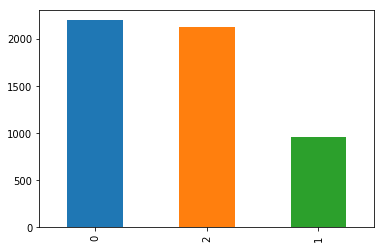

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

oof=pd.Series(oof)
oof.value_counts().plot.bar()

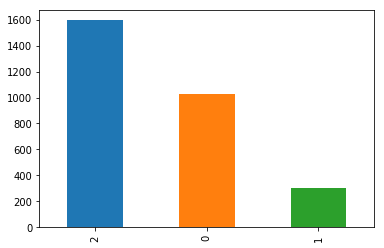

In [91]:
predictions=pd.Series(predictions)
predictions.value_counts().plot.bar()

In [92]:
predictions.value_counts()

2    1594
0    1029
1     301
dtype: int64

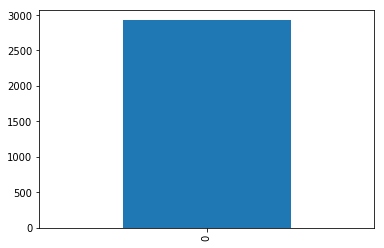

In [93]:
model1_predictions=pd.Series(model1_predictions)
model1_predictions.value_counts().plot.bar()

In [94]:
model1_predictions.value_counts()

0    2924
dtype: int64

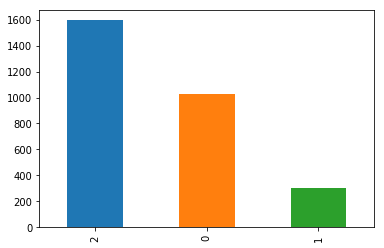

In [95]:
model4_predictions=pd.Series(model4_predictions)
model4_predictions.value_counts().plot.bar()

In [96]:
model4_predictions.value_counts()

2    1594
0    1029
1     301
dtype: int64

In [97]:
# model2 = build_model1(lr = 1e-3, lr_d = 1e-10, units = 64, spatial_dr = 0.3, kernel_size1=3, kernel_size2=2, dense_units=32, dr=0.1, conv_size=32)

In [98]:
sub=pd.read_csv('../input/innoplexusav/sample.csv')

In [99]:
sub['sentiment']=predictions
sub.to_csv('my_submission.csv',index=False)

sub['sentiment']=predictions1
sub.to_csv('my_submission1.csv',index=False)

sub['sentiment']=predictions2
sub.to_csv('my_submission2.csv',index=False)

sub['sentiment']=predictions3
sub.to_csv('my_submission3.csv',index=False)

sub['sentiment']=predictions4
sub.to_csv('my_submission4.csv',index=False)